# How to Export a Segment Anything 2 model fine-tuned in Supervisely

After you have fine-tuned a Segment Anything 2 model using corresponding app, you can download the best checkpoint from Team Files and use your trained SAM 2 model outside Supervisely Platform.

## 1. Download checkpoint from Team Files

Click on "More features" icon in the left sidebar:

![sam2_outside_sly_0](https://github.com/user-attachments/assets/aa7b815f-c476-4eed-b0ca-5724a073601e)

Open Team Files:

![sam2_outside_sly_1](https://github.com/user-attachments/assets/e8442fab-e649-49ee-af31-349544c5914f)

Right click on fine-tuned model checkpoints and select "Download" option:

![sam2_outside_sly_2](https://github.com/user-attachments/assets/afbbf21e-7298-4c0c-bb9c-c18f9700ba66)

Alternatively, you can download these files using Supervisely API:

In [ ]:
# Install supervisely SDK if not installed
!pip install supervisely

To download files via Supervisely API, you will need to define [server address](https://developer.supervisely.com/getting-started/basics-of-authentication#server_address-env), [api token](https://developer.supervisely.com/getting-started/basics-of-authentication#api_token-env) and [team ID](https://developer.supervisely.com/getting-started/environment-variables#team_id):

In [ ]:
import supervisely as sly
import os


server_address = your_server_adress
api_token = your_api_token
team_id = your_team_id
path_to_weights_in_team_files = path_to_your_checkpoint
download_dir = "./my_model"

api = sly.Api(server_address, api_token)
local_weights_path = os.path.join(download_dir, "fine-tined_sam2.pt")
api.file.download(team_id, path_to_weights_in_team_files, local_weights_path)

## 2. Install necessary libraries

You can use [official SAM 2 installation guide](https://github.com/facebookresearch/sam2/blob/2b90b9f5ceec907a1c18123530e92e794ad901a4/INSTALL.md) to install necessary dependencies.

## 3. Load fine-tuned model and input image

In [9]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch
import supervisely as sly
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2


# set image display parameters
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

# load model
checkpoint_path = "./my_model/fine-tuned_sam2.pt"
state_dict = torch.load(checkpoint_path)
config_path = state_dict["config"]
device = torch.device("cuda")
model = build_sam2(config_path, checkpoint_path, device=device)
predictor = SAM2ImagePredictor(model)

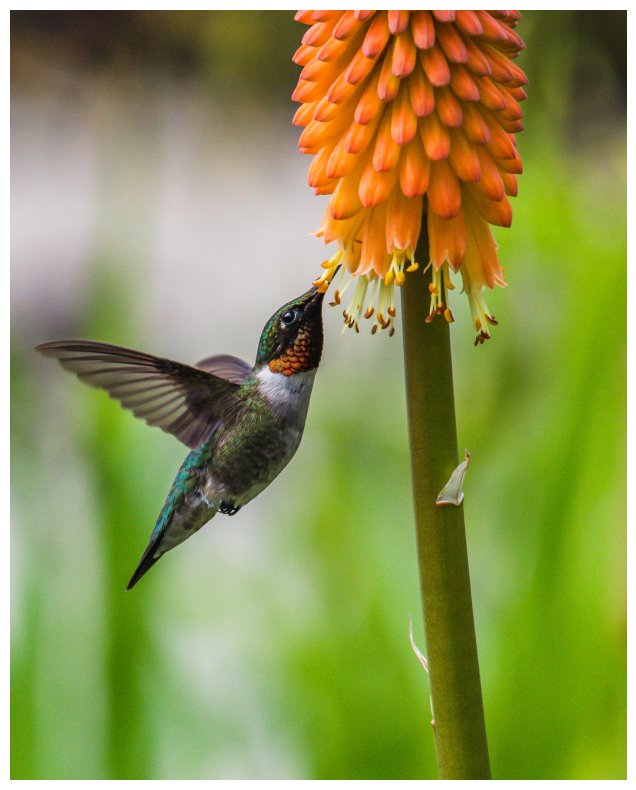

In [4]:
# load image
image_path = "image.jpg"
image_np = sly.image.read(image_path)

image = Image.fromarray(image_np)
plt.axis("off")
plt.imshow(image);

## Define input prompt

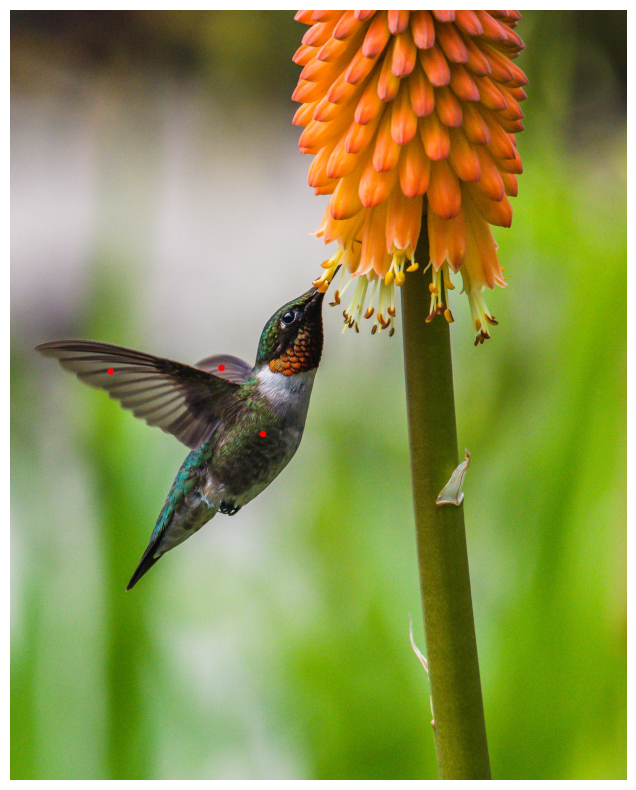

In [12]:
# define input prompt
point_coordinates = np.array([[787, 1321], [658, 1115], [313, 1126]])
point_labels = np.array([1, 1, 1])

# visualize input prompt
bitmap = image_np.copy()
for point_coordinate in point_coordinates:
    cv2.circle(
            img=bitmap,
            center=(point_coordinate[0], point_coordinate[1]),
            radius=10,
            color=(255, 0, 0),
            thickness=-1,
        )
    
bitmap = Image.fromarray(bitmap)
plt.axis("off")
plt.imshow(bitmap);

## Inference

In [13]:
# run fine-tuned model on input image
with torch.no_grad():
    with torch.cuda.amp.autocast():
        predictor.set_image(image_np)
        masks, _, _ = predictor.predict(
            point_coords=point_coordinates,
            point_labels=point_labels,
            multimask_output=False,
        )
        mask = masks[0]

mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

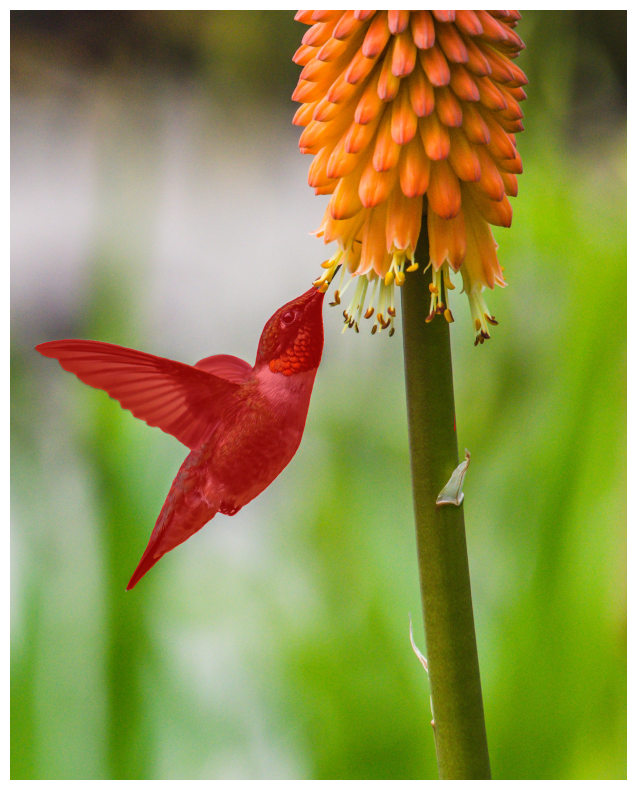

In [14]:
# generate sly annotation from predicted mask
bitmap = sly.Bitmap(mask)
obj_class = sly.ObjClass("object_mask", sly.Bitmap)
label = sly.Label(bitmap, obj_class)
img_height, img_width = image_np.shape[:2]
pred_ann = sly.Annotation(img_size=[img_height, img_width], labels=[label])
pred_img = image_np.copy()
# draw mask on image
pred_ann.draw_pretty(pred_img, thickness=1, color=[255, 0, 0])
pred_img = Image.fromarray(pred_img)
plt.axis("off")
plt.imshow(pred_img);